In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from google.colab import drive
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost

データセット読み込み

In [33]:
df = pd.read_csv('drive/My Drive/data/application_train.csv')
df_test = pd.read_csv('drive/My Drive/data/application_test.csv') 

データチェック（307511サンプル×122カラム。typeはint,float,object）

In [34]:
print(df.head(4))
print(df.info())
print(df.describe())

   SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002       1  ...                       0.0                        1.0
1      100003       0  ...                       0.0                        0.0
2      100004       0  ...                       0.0                        0.0
3      100006       0  ...                       NaN                        NaN

[4 rows x 122 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR  ...  AMT_REQ_CREDIT_BUREAU_YEAR
count  307511.000000  ...               265992.000000
mean   278180.518577  ...                    1.899974
std    102790.175348  ...                    1.869295
min    100002.000000  ...                    0.000000
25%    189145.500000  ...                    0.000000
50%    278202.000000  ...              

テストデータチェック（48744サンプル×121カラム。typeはint,float,object）

In [35]:
print(df_test.head(4))
print(df_test.info())
print(df_test.describe())

   SK_ID_CURR  ... AMT_REQ_CREDIT_BUREAU_YEAR
0      100001  ...                        0.0
1      100005  ...                        3.0
2      100013  ...                        4.0
3      100028  ...                        3.0

[4 rows x 121 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None
          SK_ID_CURR  ...  AMT_REQ_CREDIT_BUREAU_YEAR
count   48744.000000  ...                42695.000000
mean   277796.676350  ...                    1.983769
std    103169.547296  ...                    1.838873
min    100001.000000  ...                    0.000000
25%    188557.750000  ...                    0.000000
50%    277549.000000  ...                    2.000000
75%    367555.500000  ...                    3.000000
max    456250.000000  ...                   17.000000

[8 rows x 105 columns]


目的変数（ターゲット）比率確認

In [36]:
n_target0, n_target1 = len(df[df['TARGET'] == 0]), len(df[df['TARGET'] == 1])
n_all = n_target0+n_target1
print('通常債務者(target:0)の割合 :' + '{:.2%}'.format(n_target0/n_all)) #target0(通常債務者)の割合
print('不良債務者(target:1)の割合 :' + '{:.2%}'.format(n_target1/n_all)) #target1(不良債務者)の割合

通常債務者(target:0)の割合 :91.93%
不良債務者(target:1)の割合 :8.07%


グルーピング

In [37]:
grouped = df.groupby('TARGET')
print(grouped['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY'].mean())

          DAYS_BIRTH  REGION_RATING_CLIENT_W_CITY
TARGET                                           
0      -16138.176397                     2.022449
1      -14884.828077                     2.134824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


データ整理（欠損データ削除）

In [ ]:
#print(df.isnull().sum()) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）
#print(df_test.isnull().sum() / len(df)) #欠損率（欠損の発生しているカラムは少なく、またいずれも1%未満）

df.dropna(thresh=304000, axis=1, inplace=True) #3000つ以上欠損値がある特徴量（列）の削除
df.dropna(how='any', axis=0, inplace=True) #欠損値があるサンプル（行）の削除

df_test['TARGET'] = '' #↓の処理の際にTARGETカラムが無いと処理できない為、追加
df_test = df_test[df.columns] #訓練データとカラムを合わせる
df_test.fillna(0) #欠損値には0を適用

df.info()
df_test.info()

相関関係ヒートマップ

In [ ]:
df_corr = df.corr().abs() #相関関係のデータフレーム作成
df_corr.style.background_gradient(axis=None) #相関係数行列のヒートマップ

targetと相関関係の強いカラムを抽出

In [27]:
selected_cols = df_corr.nlargest(13,'TARGET')['TARGET'].index
print(selected_cols)

Index(['TARGET', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED',
       'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION'],
      dtype='object')


前処理・訓練データと検証データの分割、標準化

In [ ]:
X = df.select_dtypes(exclude=["object"]) #オブジックト列削除
X = X.drop('TARGET',axis=1).values # 説明変数(target以外の特徴量)

y = df['TARGET'].values # 目的変数(target)

t = df_test.select_dtypes(exclude=["object"]) #テストデータのオブジェクト列削除
t = t.values #ndarrayへ変換

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(t.shape)
print(type(t))
t

スコア評価関数

In [6]:
def result(y_test_, Y_pred_):
  print('accuracy_score= ' + str(accuracy_score(y_test_, Y_pred_)))#正解率（正解の割合）
  print('precision_score= '+ str(precision_score(y_test_, Y_pred_)))#適合率（陽性と予測されたサンプルのうち正解したサンプルの割合）
  print('recall_score= '+ str(recall_score(y_test_, Y_pred_)))#再現率（実際に陽性のサンプルのうち正解したサンプルの割合）
  print('f1_score= '+ str(f1_score(y_test_, Y_pred_)))#F値（適合率と再現率の調和平均）
  print('confusion_matrix= ')#混同行列
  print(confusion_matrix(y_test_, Y_pred_))

  print('AUC=' + str(roc_auc_score(y_test_, Y_pred_)))

  #ROC曲線描写
  fpr, tpr, thresholds = metrics.roc_curve(y_test_, Y_pred_)# FPR, TPR(, しきい値) を算出
  auc = metrics.auc(fpr, tpr) #auc

  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
  plt.legend()
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

決定木モデル

accuracy_score= 0.8469133099824868
precision_score= 0.1274126838235294
recall_score= 0.14786666666666667
f1_score= 0.13687978276968651
confusion_matrix= 
[[76265  7595]
 [ 6391  1109]]
AUC=0.5286495269894268


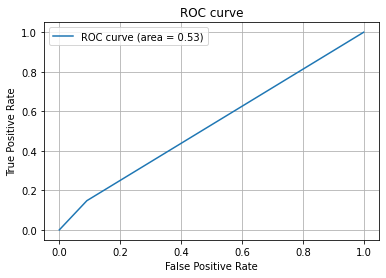

In [66]:
descision_tree = tree.DecisionTreeClassifier(random_state=0)#インスタンス作成
descision_tree.fit(X_train, y_train) # 学習
Y_pred = descision_tree.predict(X_test)# 予測　
decision_tree = result(y_test, Y_pred) #評価出力

最近傍法

In [ ]:
##10-nn
knc_10nn = KNeighborsClassifier(n_neighbors=10)
knc_10nn.fit(X_train, y_train)
Y_pred = knc_10nn.predict(X_test)# 予測
result(y_test, Y_pred)

accuracy_score= 0.9298721425803952
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[2400    5]
 [ 176    0]]
AUC=0.498960498960499


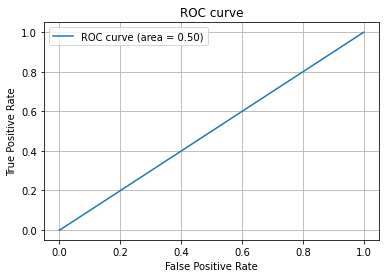

In [53]:
##5-nn
knc_5nn = KNeighborsClassifier(n_neighbors=5)
knc_5nn.fit(X_train, y_train)
Y_pred = knc_5nn.predict(X_test)# 予測　
result(y_test, Y_pred)

accuracy_score= 0.8934521503293297
precision_score= 0.0975609756097561
recall_score= 0.06818181818181818
f1_score= 0.0802675585284281
confusion_matrix= 
[[2294  111]
 [ 164   12]]
AUC=0.511013986013986


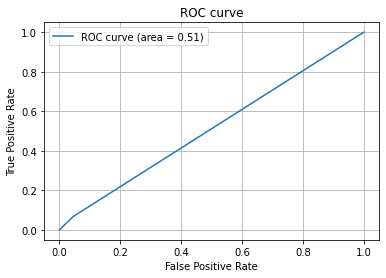

In [54]:
##1-nn
knc_nn1 = KNeighborsClassifier(n_neighbors=1)
knc_nn1.fit(X_train, y_train)
Y_pred = knc_nn1.predict(X_test)# 予測　
result(y_test, Y_pred)

ロジスティック回帰

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score= 0.9179632402404357
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[84605     0]
 [ 7561     0]]
AUC=0.5


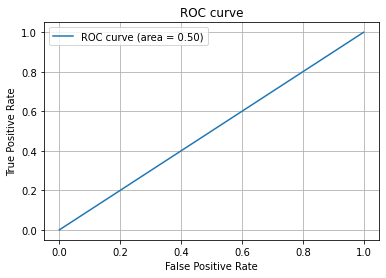

In [ ]:
lr = LogisticRegression(random_state=0) # インスタンスを作成
lr.fit(X_train, y_train) # 学習
Y_pred = lr.predict(X_test)# 予測　
logistic_regression = result(y_test, Y_pred) #評価出力

SVM

In [ ]:
clf = SVC(random_state=0)#インスタンス作成
clf.fit(X_train, y_train) # 学習
Y_pred = clf.predict(X_test)# 予測　
svm = result(y_test, Y_pred) #評価出力

ランダムフォレスト

accuracy_score= 0.9179632402404357
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[84605     0]
 [ 7561     0]]
AUC=0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


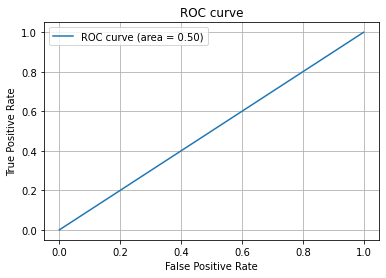

In [ ]:
rfc = RandomForestClassifier(random_state=0)#インスタンス作成
rfc.fit(X_train, y_train) # 学習
Y_pred = rfc.predict(X_test)# 予測　
random_forest = result(y_test, Y_pred) #評価出力

LightGBM

accuracy_score= 0.9179632402404357
precision_score= 0.0
recall_score= 0.0
f1_score= 0.0
confusion_matrix= 
[[84605     0]
 [ 7561     0]]
AUC=0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


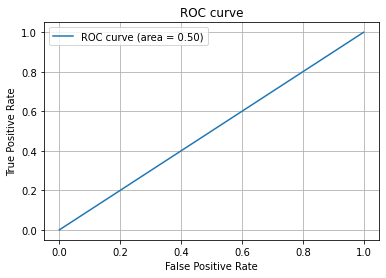

In [ ]:
lgbm = lgb.LGBMClassifier(random_state=0) # モデルのインスタンスの作成
lgbm.fit(X_train, y_train) # モデルの学習
Y_pred = lgbm.predict(X_test)
lgbm = result(y_test, Y_pred) #評価出力

決定木手法を使用し、評価データ（テストデータ）を適用

In [40]:
descision_tree = tree.DecisionTreeClassifier(random_state=0)#インスタンス作成
descision_tree.fit(X_train, y_train) # 学習
Y_pred = descision_tree.predict(t)# 予測　

ValueError: ignored

特徴量エンジニアリング（one-hot-encording)

In [ ]:
ohe_columns = ['CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR']
df = pd.get_dummies(df, columns=ohe_columns)

特徴量エンジニアリング（OrdinalEncoder）

In [ ]:
df_temp = df[['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']] #一時的に代入
#df_temp = df.select_dtypes(include='object') #一時的に代入

oe = OrdinalEncoder()
oe.fit(df_temp)
df_trans = oe.transform(df_temp)
df[['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']] = df_trans